<a href="https://colab.research.google.com/github/Rakshit-Sawarn-iitb/WIDS-Brain-Tumor-Detection/blob/main/BrainTumorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import gc
import os
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dir = "/content/drive/MyDrive/brain_tumor_dataset"
paths = []
labels = []

for label in ['yes', 'no']:
  for dirname, _, filenames in os.walk(os.path.join(dir,label)):
        for filename in filenames:
            paths.append(os.path.join(dirname, filename))
            labels.append(1 if label is 'yes' else 0)

len(paths), len(labels)

<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-3-99b34089f5dd>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  labels.append(1 if label is 'yes' else 0)


(263, 263)

In [4]:
sizes = []
for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()

print(max(sizes), min(sizes))

(1920, 1080) (150, 198)


In [49]:
X_train, X_test, y_train, y_test = train_test_split(paths, labels, stratify=labels, test_size=0.2, shuffle=True, random_state=1357)
print(len(X_train), len(X_test))

210 53


In [50]:
class MRIDataset():
    def __init__(self, paths, labels, augmentations=None):
      self.paths = paths
      self.labels = labels

      if augmentations is None:
          self.augmentations = transforms.Compose([transforms.ToTensor()])
      else:
          self.augmentations = augmentations

    def __len__(self):
      return len(self.paths)

    def __getitem__(self, index):
      label = self.labels[index]

      sample = Image.open(self.paths[index]).convert(mode="RGB")
      sample = self.augmentations(sample)

      return (sample,torch.tensor(label, dtype=torch.float))

In [51]:
train_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.RandomHorizontalFlip(0.2),
                                          transforms.RandomVerticalFlip(0.1),
                                          transforms.RandomAutocontrast(0.2),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ToTensor()
                                         ])

test_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.RandomHorizontalFlip(0.2),
                                          transforms.RandomVerticalFlip(0.1),
                                          transforms.RandomAutocontrast(0.2),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ToTensor()
                                         ])

In [52]:
train_dataset = MRIDataset(X_train, y_train, augmentations=train_augmentations)
test_dataset = MRIDataset(X_test, y_test, augmentations=test_augmentations)

tensor([[[0.0039, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         [0.0039, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         [0.0039, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.0039, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         [0.0039, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         [0.0039, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.0039, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         [0.0039, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         [0.0039, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.

TypeError: Invalid shape (3, 224, 224) for image data

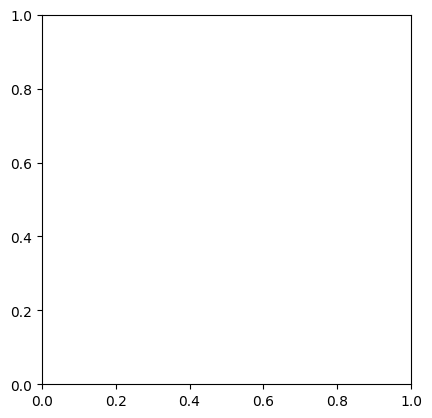

In [9]:
random_sample, random_label = test_dataset[0]
print(random_sample)
plt.imshow(random_sample)
print(random_label.item())

In [53]:
class Config:
    learning_rate = 1e-3
    epochs = 10
    train_batch_size = 8
    test_batch_size = 8

In [54]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = Config.train_batch_size,
                                               shuffle = True,
                                               num_workers = 2
                                              )

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = Config.test_batch_size,
                                              shuffle = True,
                                              num_workers = 2
                                              )

len(train_dataloader), len(test_dataloader)

(27, 7)

In [55]:
class Model(nn.Module):

    def __init__(self, in_features=3):
        super(Model, self).__init__()


        self.conv_block = nn.Sequential(nn.Conv2d(in_channels=in_features,
                                                 out_channels=32,
                                                 kernel_size=3,
                                                 stride=1
                                                 ),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2),

                                       nn.Conv2d(in_channels=32,
                                                 out_channels=64,
                                                 kernel_size=3,
                                                 stride=1
                                                ),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2)
                                      )

        self.linear_block = nn.Sequential(nn.Linear(64*54*54, 1024),
                                          nn.ReLU(),
                                          nn.Dropout(0.5),
                                          nn.Linear(1024,256),
                                          nn.ReLU(),
                                          nn.Dropout(0.3),
                                          nn.Linear(256,1)
                                         )


    def forward(self,x):
        x = self.conv_block(x)
        x = torch.flatten(x,1)
        x = self.linear_block(x)
        return x

In [56]:
model = Model()
print(model)

Model(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=186624, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [58]:
class Trainer:

    def __init__(self, model, dataloaders, Config):
        self.model = model
        self.train, self.test = dataloaders

        self.Config = Config

        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.Config.learning_rate)
        self.loss_fn = nn.BCEWithLogitsLoss()


    def binary_accuracy(self, outputs, labels):
        return (torch.round(torch.sigmoid(outputs)) == labels).sum().item() / labels.shape[0]


    def train_one_epoch(self):

        running_loss = 0
        running_acc = 0

        for X,y in self.train:

            X = X.to(device, dtype = torch.float)
            y = y.reshape(y.shape[0],1)
            y = y.to(device, dtype = torch.float)

            self.optim.zero_grad()

            outputs = self.model(X)
            loss = self.loss_fn(outputs, y)

            loss.backward()
            self.optim.step()

            running_loss += loss.item()
            running_acc += self.binary_accuracy(outputs, y)

            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()

        train_loss = running_loss / len(self.train)
        train_acc = running_acc / len(self.train)

        return train_loss, train_acc


    def fit(self):

        losses = []
        accuracies = []

        for epoch in range(self.Config.epochs):

            self.model.train()

            train_loss, train_acc = self.train_one_epoch()
            losses.append(train_loss)
            accuracies.append(train_acc)
            print(f"EPOCH {epoch+1}/{self.Config.epochs}")
            print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc}\n\n")


    @torch.no_grad()
    def inference(self):

        self.model.eval()

        running_acc = 0

        for X,y in self.test:

            X = X.to(device, torch.float)
            y = y.reshape(y.shape[0],1)
            y = y.to(device, dtype = torch.float)
            outputs = self.model(X)
            running_acc += self.binary_accuracy(outputs, y)

            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()

        accuracy = (running_acc / len(self.test))*100

        return accuracy

In [ ]:
trainer = Trainer(model, (train_dataloader, test_dataloader), Config)
trainer.fit()